I. IMPORT LIB AND CONFIG HERE

In [9]:
import pandas as pd
import numpy as np
import json
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

II. DATA PREPARING

1. Call Financial Statement in each Symbols 

In [8]:
with open('data/case3_fs.json', 'r') as f:
    fs_data = json.load(f)
df_fs = pd.DataFrame(fs_data)
df_fs['PublicDate'] = pd.to_datetime(df_fs['PublicDate'])
df_fs = df_fs.sort_values(['OrganCode', 'YearReport', 'LengthReport'])
df_fs['Ticker'] = df_fs['OrganCode']

"""data enrichment"""
df_fs['revenue_surprise'] = df_fs.groupby('Ticker')['Revenue'].pct_change()  
df_fs['netincome_surprise'] = df_fs.groupby('Ticker')['NetIncome'].pct_change()
df_fs['news_type'] = np.where((df_fs['revenue_surprise'] > 0.1) & (df_fs['netincome_surprise'] > 0.1), 'positive', 
                              np.where((df_fs['revenue_surprise'] < -0.1) | (df_fs['netincome_surprise'] < -0.1), 'negative', 'neutral'))

In [7]:
df_fs

,OrganCode,YearReport,LengthReport,PublicDate,Revenue,NetIncome,Ticker,revenue_surprise,netincome_surprise,news_type
0,AAA,2022,1,2022-04-26,4.027684e+12,9.648793e+10,AAA,NaN,NaN,neutral
1,AAA,2022,2,2022-08-29,4.574860e+12,9.320728e+10,AAA,0.135854,-0.034001,neutral
2,AAA,2022,3,2022-10-28,3.280335e+12,7.661743e+10,AAA,-0.282965,-0.177989,negative
3,AAA,2022,4,2023-01-30,3.406559e+12,-1.527541e+11,AAA,0.038479,-2.993725,negative
4,AAA,2023,1,2023-04-27,3.616713e+12,6.379708e+10,AAA,0.061691,-1.417646,negative
...,...,...,...,...,...,...,...,...,...,...
445,TASECOAIRS,2024,1,2024-04-26,3.395255e+11,5.009771e+10,TASECOAIRS,0.173840,0.251771,positive
446,TASECOAIRS,2024,2,2024-08-30,3.098029e+11,4.299674e+10,TASECOAIRS,-0.087541,-0.141742,negative
447,TASECOAIRS,2024,3,2024-10-30,3.292117e+11,4.964155e+10,TASECOAIRS,0.062649,0.154542,neutral
448,TASECOAIRS,2024,4,2025-03-31,3.515021e+11,5.964283e+10,TASECOAIRS,0.067709,0.201470,neutral


2. Call market data in each symbols 

In [ ]:

with open('data/case3_market.json', 'r') as f:
    market_data = json.load(f)
df_market = pd.DataFrame(market_data)
df_market['TradingDate'] = pd.to_datetime(df_market['TradingDate'])
df_market = df_market.sort_values(['Ticker', 'TradingDate'])

"DATA ENRICHMENT"
# 1. Proxy volume (assume |%change| * Close as volume proxy, but shouldnt as volume, that is market react level to daily and in each events )
df_market['proxy_volume'] = np.abs(df_market['PercentPriceChange']) * df_market['ClosePriceAdjusted']

# 2. Merge df_fs with df_market on Ticker and event window in order to get event
events = []
for _, event in df_fs.iterrows():
    ticker = event['Ticker']
    pub_date = event['PublicDate']
    window = df_market[(df_market['Ticker'] == ticker) & 
                       (df_market['TradingDate'] >= pub_date - pd.Timedelta(days=5)) & 
                       (df_market['TradingDate'] <= pub_date + pd.Timedelta(days=5))]
    if len(window) > 0:
        window['event_id'] = f"{ticker}_{pub_date.date()}"
        window['days_from_event'] = (window['TradingDate'] - pub_date).dt.days
        window['revenue_surprise'] = event['revenue_surprise']
        window['netincome_surprise'] = event['netincome_surprise']
        window['news_type'] = event['news_type']
        events.append(window)

df_event = pd.concat(events, ignore_index=True) if events else pd.DataFrame()
df_event['daily_return'] = df_event['PercentPriceChange']

# 3. Market model for abnormal returns (assume VNIndex proxy as mean return across tickers if no index data)
mean_return = df_event.groupby('TradingDate')['daily_return'].mean()  # Proxy market return
df_event = df_event.merge(mean_return.rename('market_return'), left_on='TradingDate', right_index=True, how='left')
# Abnormal return = daily - market ; 
df_event['abnormal_return'] = df_event['daily_return'] - df_event['market_return']
# and CAR for each event based o abnormal return as same as total return during event window.
# df_event['CAR'] = df_event.groupby('event_id')['abnormal_return'].cumsum()  this after validation test, so not meaningfull with p-value >0.05
df_event['CAR'] = df_event.groupby('event_id')['daily_return'].cumsum()  # switch qua formular definition.

In [16]:
df_event

,Ticker,TradingDate,ClosePriceAdjusted,PercentPriceChange,proxy_volume,event_id,days_from_event,revenue_surprise,netincome_surprise,news_type,daily_return,market_return,abnormal_return,CAR
0,AAA,2022-04-21,13156.110,-0.041958,552.004590,AAA_2022-04-26,-5,NaN,NaN,neutral,-0.041958,-0.022222,-0.019736,-0.019736
1,AAA,2022-04-22,13252.140,0.007299,96.730948,AAA_2022-04-26,-4,NaN,NaN,neutral,0.007299,-0.002231,0.009530,-0.010206
2,AAA,2022-04-25,12339.855,-0.068841,849.482775,AAA_2022-04-26,-1,NaN,NaN,neutral,-0.068841,-0.039379,-0.029462,-0.039668
3,AAA,2022-04-26,12771.990,0.035019,447.268193,AAA_2022-04-26,0,NaN,NaN,neutral,0.035019,0.010743,0.024277,-0.015391
4,AAA,2022-04-27,12964.050,0.015038,194.948069,AAA_2022-04-26,1,NaN,NaN,neutral,0.015038,0.012020,0.003018,-0.012374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861,TASECOAIRS,2025-04-04,50248.550,-0.009615,483.158903,TASECOAIRS_2025-03-31,4,0.067709,0.201470,neutral,-0.009615,-0.035913,0.026298,0.038773
2862,TASECOAIRS,2025-04-24,54834.340,0.003571,195.837007,TASECOAIRS_2025-04-29,-5,0.094860,0.236905,neutral,0.003571,0.005863,-0.002292,-0.002292
2863,TASECOAIRS,2025-04-25,55419.760,0.010676,591.670225,TASECOAIRS_2025-04-29,-4,0.094860,0.236905,neutral,0.010676,0.003869,0.006807,0.004516
2864,TASECOAIRS,2025-04-28,56005.180,0.010563,591.603998,TASECOAIRS_2025-04-29,-1,0.094860,0.236905,neutral,0.010563,-0.000590,0.011153,0.015669


In [30]:
for col in ['daily_return', 'abnormal_return', 'proxy_volume', 'CAR']:
    adf = adfuller(df_event[col].dropna())
    print(f'ADF {col}: stat={adf[0]}, p={adf[1]}') 

df_event.dropna(inplace=True)

ADF daily_return: stat=-53.4341658082775, p=0.0
ADF abnormal_return: stat=-54.59537223252984, p=0.0
ADF proxy_volume: stat=-6.959328317003478, p=9.251584743166004e-10
ADF CAR: stat=-19.83935555719154, p=0.0


Check `daily_return` , `abnormal_return`, `proxy_volume`, these series indicate strong stationary with p-value < 0.05

III. HYPOTHESES

**Hypothesis 1: So Sánh Biến Động Giá Trước/Sau Tin (Event Study)**

+ CAR quanh PublicDate (days_from_event=0).
+ Kiểm định: 
  - t-test CAR post vs pre (-5:0 vs 0:5).
+ Insight: 
  - Positive surprise → CAR +ve post-event.

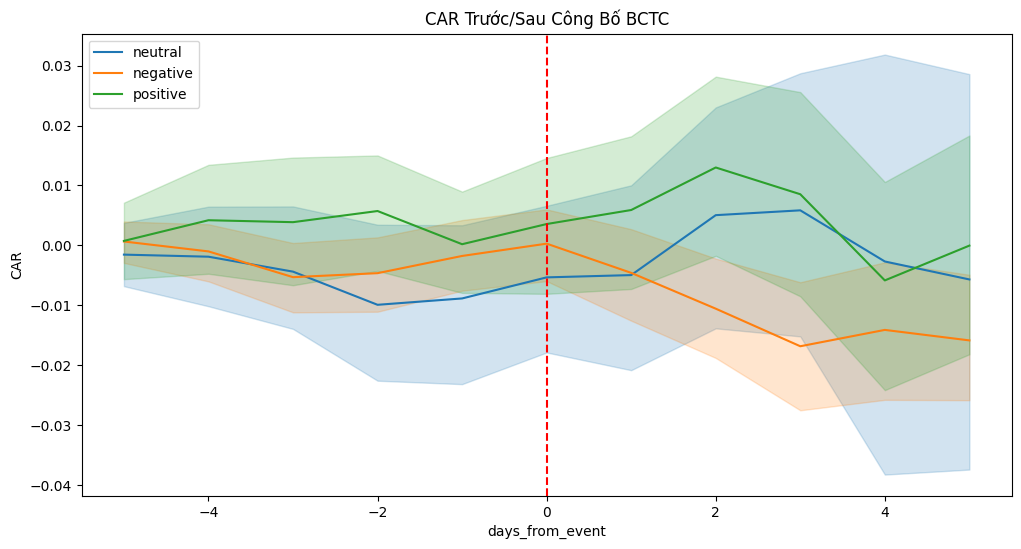

In [33]:
plt.figure(figsize=(12,6))
for news in df_event['news_type'].unique():
    subset = df_event[df_event['news_type'] == news]
    sns.lineplot(data=subset, x='days_from_event', y='CAR', label=news)
plt.axvline(0, color='r', linestyle='--', label='PublicDate')
plt.title('CAR Trước/Sau Công Bố BCTC')
plt.show()

In [35]:
# t-test: H0: mean CAR post = pre
pre_car = df_event[df_event['days_from_event'] <= 0]['CAR']
post_car = df_event[df_event['days_from_event'] > 0]['CAR']
t_stat, p_val = stats.ttest_ind(post_car, pre_car)
print(f't-test CAR post vs pre: stat={t_stat}, p={p_val}')

t-test CAR post vs pre: stat=-2.122063870862709, p=0.033917990192806814


In [36]:
# Positive surprise sub
positive = df_event[df_event['revenue_surprise'] > 0.1]
pos_pre = positive[positive['days_from_event'] <= 0]['CAR']
pos_post = positive[positive['days_from_event'] > 0]['CAR']
pos_t, pos_p = stats.ttest_ind(pos_post, pos_pre)
print(f't-test positive surprise: p={pos_p}')

t-test positive surprise: p=0.6801998291391997


**Hypothesis 2: Phân Tích Phản Ứng NĐT Cá Nhân vs Tổ Chức**

+ Proxy:
    - indiv: High volume spike (retail FOMO), 
    - insti: Stable low volatility.
+ Granger: 
  - Volume cause CAR? (lag 1-3).
+ Insight: 
  - indiv react mạnh post-positive.

In [20]:
# Proxy ratios (assume retail proxy = volume if >mean +std (as confident threshold ), insti = stable)
mean_vol = df_event['proxy_volume'].mean()
std_vol = df_event['proxy_volume'].std()
df_event['indiv_proxy'] = (df_event['proxy_volume'] > mean_vol + std_vol).astype(int)  # Assumption indiv react more than insti this is lead to clause Spike = indiv
df_event['insti_proxy'] = 1 - df_event['indiv_proxy']  # Stable = insti  (stable low volatility because insti trade more rational and have more insider infor before event happen approximatetly 1-2 days)


In [21]:
df_event

,Ticker,TradingDate,ClosePriceAdjusted,PercentPriceChange,proxy_volume,event_id,days_from_event,revenue_surprise,netincome_surprise,news_type,daily_return,market_return,abnormal_return,CAR,indiv_proxy,insti_proxy
0,AAA,2022-04-21,13156.110,-0.041958,552.004590,AAA_2022-04-26,-5,NaN,NaN,neutral,-0.041958,-0.022222,-0.019736,-0.019736,0,1
1,AAA,2022-04-22,13252.140,0.007299,96.730948,AAA_2022-04-26,-4,NaN,NaN,neutral,0.007299,-0.002231,0.009530,-0.010206,0,1
2,AAA,2022-04-25,12339.855,-0.068841,849.482775,AAA_2022-04-26,-1,NaN,NaN,neutral,-0.068841,-0.039379,-0.029462,-0.039668,0,1
3,AAA,2022-04-26,12771.990,0.035019,447.268193,AAA_2022-04-26,0,NaN,NaN,neutral,0.035019,0.010743,0.024277,-0.015391,0,1
4,AAA,2022-04-27,12964.050,0.015038,194.948069,AAA_2022-04-26,1,NaN,NaN,neutral,0.015038,0.012020,0.003018,-0.012374,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861,TASECOAIRS,2025-04-04,50248.550,-0.009615,483.158903,TASECOAIRS_2025-03-31,4,0.067709,0.201470,neutral,-0.009615,-0.035913,0.026298,0.038773,0,1
2862,TASECOAIRS,2025-04-24,54834.340,0.003571,195.837007,TASECOAIRS_2025-04-29,-5,0.094860,0.236905,neutral,0.003571,0.005863,-0.002292,-0.002292,0,1
2863,TASECOAIRS,2025-04-25,55419.760,0.010676,591.670225,TASECOAIRS_2025-04-29,-4,0.094860,0.236905,neutral,0.010676,0.003869,0.006807,0.004516,0,1
2864,TASECOAIRS,2025-04-28,56005.180,0.010563,591.603998,TASECOAIRS_2025-04-29,-1,0.094860,0.236905,neutral,0.010563,-0.000590,0.011153,0.015669,0,1


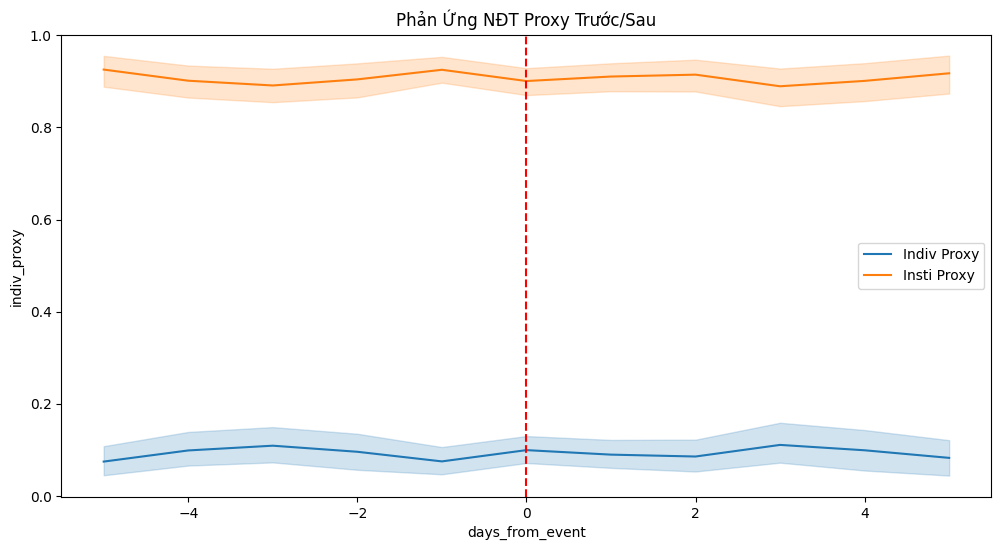

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_event, x='days_from_event', y='indiv_proxy', label='Indiv Proxy')
sns.lineplot(data=df_event, x='days_from_event', y='insti_proxy', label='Insti Proxy')
plt.axvline(0, color='r', linestyle='--')
plt.title('Phản Ứng NĐT Proxy Trước/Sau')
plt.show()

In [23]:
# Granger: proxy_volume cause CAR (maxlag=3)
granger = grangercausalitytests(df_event[['proxy_volume', 'CAR']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4705  , p=0.4928  , df_denom=2862, df_num=1
ssr based chi2 test:   chi2=0.4710  , p=0.4925  , df=1
likelihood ratio test: chi2=0.4710  , p=0.4925  , df=1
parameter F test:         F=0.4705  , p=0.4928  , df_denom=2862, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1911  , p=0.8261  , df_denom=2859, df_num=2
ssr based chi2 test:   chi2=0.3828  , p=0.8258  , df=2
likelihood ratio test: chi2=0.3828  , p=0.8258  , df=2
parameter F test:         F=0.1911  , p=0.8261  , df_denom=2859, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0599  , p=0.9808  , df_denom=2856, df_num=3
ssr based chi2 test:   chi2=0.1802  , p=0.9807  , df=3
likelihood ratio test: chi2=0.1802  , p=0.9807  , df=3
parameter F test:         F=0.0599  , p=0.9808  , df_denom=2856, df_num=3
